# Solving PDE's with feed forward neural networks using Autograd

#### Implementation feed forward procedure, the learning scheme, and setting up the weights and biases:

In [69]:
import autograd.numpy as np
from autograd import grad, elementwise_grad, jacobian
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys


def feedforward(X, P, act_func):
    """
    Feed forward precedure for a network
    define by the weights and biases P, 
    and the activation functions act_func.
    """
    
    dim = len(P)
    z = np.array(X)
    
    for i in range(dim):
        z = np.concatenate((z, np.ones((z.shape[0], 1))), axis=1)
        z = act_func[i](z @ P[i])

    return z


def gradient_decent(X, P, act_func, cost, mu, N):
    gradient = elementwise_grad(cost, 1)
    
    for i in range(N):
        grad = gradient(X, P, act_func)    
        
        for j in range(len(P)):
            P[j] -= mu*grad[j]
            
        if i%(N/100) == 0:
            loss = cost(X, P, act_func)
            sys.stdout.write(f"loss={loss:.3}, {i/(N/100)}/100\r")
            sys.stdout.flush()

    
def adam(X, P, act_func, cost, mu, N):
    b1 = 0.9
    b2 = 0.999
    eps = 1e-8
    
    m = m_old = [np.zeros(P[i].shape) for i in range(len(P))]
    v = v_old = [np.zeros(P[i].shape) for i in range(len(P))]
    
    
    gradient = elementwise_grad(cost, 1)
    
    for i in range(N):
        grad = gradient(X, P, act_func)    
        
        m = [b1*m_old[j] + (1 - b1)*grad[j]    for j in range(len(P))]
        v = [b2*v_old[j] + (1 - b2)*grad[j]**2 for j in range(len(P))]
        
        m_corr = [m[j]/(1 - b1**(i+1)) for j in range(len(P))]
        v_corr = [v[j]/(1 - b2**(i+1)) for j in range(len(P))]
        
        
        for j in range(len(P)):
            P[j] -= mu* m_corr[j]/(np.sqrt(v_corr[j]) + eps)
            
        m_old = m
        v_old = v
            
        if i%(N/100) == 0:
            loss = cost(X, P, act_func)
            sys.stdout.write(f"loss={loss:.3}, {i/(N/100)}/100\r")
            sys.stdout.flush()
            

def generate_P(dim):
    """
    Setting up the weights and biases to 
    normally distributes values. The dimmensions 
    are given by dim.
    """
    n = len(dim) - 1
    P = n * [None]
    for i in range(n):
        P[i] = np.random.normal(0, 1, (dim[i] + 1, dim[i + 1]))

    return P


def learning_rate(start_mu, stop_mu, N_cap, N):
    """
    Generates an array of learning rates, starting 
    at start_mu and capping at stop_mu after N_cap 
    number of steps, for a total of N steps
    """
    mu1 = np.linspace(start_mu, stop_mu, N_cap)
    mu2 = stop_mu*np.ones(N - N_cap)
    mu = np.concatenate((mu1, mu2))
    return mu


def ray_quo(A, x):
    """
    Calculates a list of Rayleigh Quotients    
    from the matrix A and a list of the vectors x
    """
    x = x/np.sqrt(np.einsum("ij,ij->i", x, x)[:,np.newaxis])
    eig = np.einsum("ij,ij->i", x@A, x)
    return eig

## 1D Heat Equation

#### Setting up the trial function, cost function and gradient:

In [58]:
def initial_condition(x):
    return np.sin(np.pi*x)


def g_trial(x, t, P, act_func):
    X = [*zip(x,t)]
    return (1 - t)*initial_condition(x) + t*(1 - x)*x*feedforward(X, P, act_func)[:,0]


g_trial_x = elementwise_grad(g_trial, 0)
g_trial_xx = elementwise_grad(g_trial_x, 0)
g_trial_t = elementwise_grad(g_trial, 1)


def cost(X, P, act_func):
    x, t = X[:, 0], X[:, 1]
    LHS = g_trial_xx(x, t, P, act_func)
    RHS = g_trial_t(x, t, P, act_func)
    
    return np.mean((LHS - RHS)**2)


def analytical(x,t):
    return np.sin(np.pi*x)*np.exp(-np.pi**2*t)

### Setting up function for generating and training different models

In [59]:
def generate_PINN(N_x, N_t, dim, act_func, N, mu):
    #temporal and spacial grid
    x_train = np.linspace(0, 1, N_x)
    t_train = np.linspace(0, 1, N_t)

    #using meshgrid and ravel to make a set of points in space and time
    X = np.meshgrid(x_train, t_train)
    X = zip(X[0].ravel(), X[1].ravel())
    X = np.array([*X])

    #setting up dimmensions of network and choosing activation functions
    P = generate_P(dim)

    adam(X, P, act_func, cost, mu, N)
    
    return P

In [34]:
np.random.seed(42)

P = []
act_func = [np.tanh, np.tanh, lambda x: x]
hidden_layer = [(2, 38, 13, 1), (2, 75, 25, 1), (2, 150, 50, 1)]
N_res = [5, 10, 15]

counter = 0
for n in N_res:
    for h in hidden_layer:
        P.append(generate_PINN(n, n, h, act_func, 1000, 1e-2))
        counter += 1
        print(f"{counter}/{len(hidden_layer)*len(N_res)}\n")

KeyboardInterrupt: 

#### Function for plotting the solutions:

In [35]:
def plot_function(x_grid, t_grid, u):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(x_grid, t_grid, u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    ax.view_init(20, 10)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    plt.show()
    
def mse(y, y_pred):
    return np.mean((y - y_pred)**2)

In [36]:
N = 100
x = np.linspace(0, 1, N)
t = np.linspace(0, 1, N)

x_grid, t_grid = np.meshgrid(x, t)
X = np.array([*zip(x_grid.ravel(), t_grid.ravel())])

u_nn = g_trial(X[:,0], X[:,1], P[-1], act_func)
u_nn = u_nn.reshape(N, N)

u_anal = analytical(X[:,0], X[:,1])
u_anal = u_anal.reshape(N, N)

plot_function(x_grid, t_grid, u_nn)
plot_function(x_grid, t_grid, u_anal)
plot_function(x_grid, t_grid, u_nn - u_anal)

print("MSE: ", mse(u_anal, u_nn))

IndexError: list index out of range

# Solving Coupled ODE's using FFNN to find Eigenvalues

### Set up trial function, ODE and cost function

In [70]:
def g_trial(t, P, act_func):
    return np.exp(-t)*x0 +  (1-np.exp(-t))*feedforward(t, P, act_func)


g_trial_t = jacobian(g_trial)


def f(A, x):
    return (x.T@x)*A@x - (x.T@A@x)*x
  

def cost(t, P, act_func):
    x = g_trial(t, P, act_func)
    
    LHS = g_trial_t(t, P, act_func)
    LHS = np.array([LHS[i,:,i].flatten() for i in range(len(t))])

    RHS = np.array([f(A,i).flatten() for i in x])
    
    return np.mean((LHS - RHS)**2)
    

gradient = elementwise_grad(cost,1)

def sigmoid(x):
    1/(1 - np.exp(t))

### Setting up function for generating and training different models

In [82]:
def generate_PINN(N_t, dim, act_func, N, mu):
    #temporal and spacial grid
    t_train = np.linspace(0, 1, N_t)[:, np.newaxis]

    #setting up dimmensions of network and choosing activation functions
    P = generate_P(dim)

    adam(t_train, P, act_func, cost, mu, N)
    
    return P

In [85]:
np.random.seed(42)

A = -np.array([[3, 2, 4], [2, 0 , 2], [4, 2, 3]])
x0 = np.array([1, 0, 0])
print(np.linalg.eig(A))



P = []
act_func = [np.tanh, np.tanh, lambda x: x]
hidden_layer = [(1, 150, 50, 3)]
N_res = [11]

mu = 1e-2

counter = 0
for n in N_res:
    for h in hidden_layer:
        P.append(generate_PINN(n, h, act_func, 10000, mu))
        counter += 1
        print(f"{counter}/{len(hidden_layer)*len(N_res)}\n")


        
"""
n_train = 20
n_plot = 100

T = 3
t_train = np.expand_dims(np.linspace(0, T, n_train), axis = -1)
t_plot = np.linspace(0, T, n_plot)

dt = T/n_plot
x = [np.array([1, 0, 0])]
for i in range(n_plot-1):
    x.append(x[-1] + dt*f(A, x[-1]))
    
x = np.array(x)
v = x
v = v/np.sqrt(np.einsum("ij,ij->i", v, v)[:,np.newaxis])
eig = np.einsum("ij,ij->i", v@A, v)

fig, ax = plt.subplots()
plot, = ax.plot(t_plot, eig)
ax.plot(t_plot, eig)

N = 3000

P = generate_P((1, 100, 50, 3))

mu = learning_rate(1e-7, 5e-4, 1000, N)
for i in range(N):
    if i % (N / 100) == 0:
        print(i / (N / 100))
        #print(mu[i])
        print(cost(t_train, P, act_func))
        print("-------------")
        
   
    gradient = grad(t_train, P, act_func)
    
    P[0] -= mu[i] * gradient[0]
    P[1] -= mu[i] * gradient[1]
    P[2] -= mu[i] * gradient[2]
    
    v = g_trial(t_plot[:,np.newaxis], P, act_func)
    
    
    plot.set_ydata(eig)
    fig.canvas.draw() 
"""

(array([ 1., -8.,  1.]), array([[ 0.74535599, -0.66666667, -0.21539222],
       [-0.2981424 , -0.33333333, -0.77010996],
       [-0.59628479, -0.66666667,  0.6004472 ]]))
1/1s=0.0841, 99.0/1000



'\nn_train = 20\nn_plot = 100\n\nT = 3\nt_train = np.expand_dims(np.linspace(0, T, n_train), axis = -1)\nt_plot = np.linspace(0, T, n_plot)\n\ndt = T/n_plot\nx = [np.array([1, 0, 0])]\nfor i in range(n_plot-1):\n    x.append(x[-1] + dt*f(A, x[-1]))\n    \nx = np.array(x)\nv = x\nv = v/np.sqrt(np.einsum("ij,ij->i", v, v)[:,np.newaxis])\neig = np.einsum("ij,ij->i", v@A, v)\n\nfig, ax = plt.subplots()\nplot, = ax.plot(t_plot, eig)\nax.plot(t_plot, eig)\n\nN = 3000\n\nP = generate_P((1, 100, 50, 3))\n\nmu = learning_rate(1e-7, 5e-4, 1000, N)\nfor i in range(N):\n    if i % (N / 100) == 0:\n        print(i / (N / 100))\n        #print(mu[i])\n        print(cost(t_train, P, act_func))\n        print("-------------")\n        \n   \n    gradient = grad(t_train, P, act_func)\n    \n    P[0] -= mu[i] * gradient[0]\n    P[1] -= mu[i] * gradient[1]\n    P[2] -= mu[i] * gradient[2]\n    \n    v = g_trial(t_plot[:,np.newaxis], P, act_func)\n    \n    \n    plot.set_ydata(eig)\n    fig.canvas.draw()

<IPython.core.display.Javascript object>


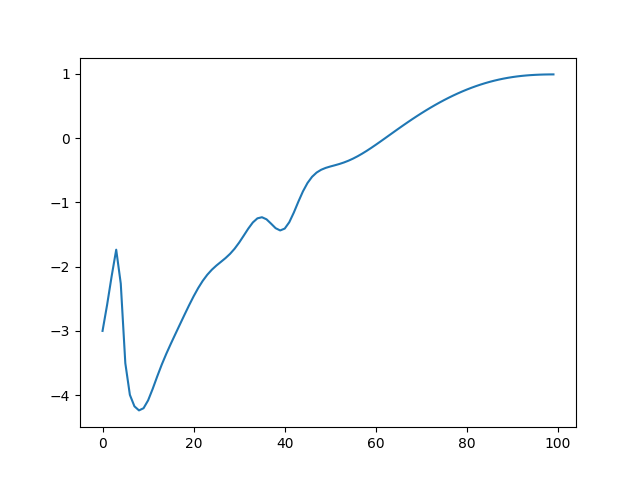

In [86]:
t_plot = np.linspace(0, 1, 100)
v = g_trial(t_plot[:,np.newaxis], P[0], act_func)
v = v/np.sqrt(np.einsum("ij,ij->i", v, v)[:,np.newaxis])

eig = ray_quo(A, v)
plt.plot(eig)
plt.show()

In [ ]:
"""
for i in range(N):
    if i % (N / 100) == 0:
        print(i / (N / 100))
        print(cost(t, P, act_func))
        print("-------------")
   
    gradient = grad(t, P, act_func)

    P[0] -= 0.000001 * gradient[0]
    P[1] -= 0.000001 * gradient[1]
    P[2] -= 0.000001 * gradient[2]

print(cost(t, P, act_func))

v = g_trial(np.array([[10]]), P, act_func)
print(v.shape)
print(v@A@v.T/(v@v.T))
"""
"""
for i in range(N):
    if i % (N / 100) == 0:
        print(i / (N / 100))
        print(cost(t, P, act_func))
        print("-------------")
   
    gradient = grad(t, P, act_func)

    P[0] -= 0.0001 * gradient[0]
    P[1] -= 0.0001 * gradient[1]

print(cost(x, P, act_func))
"""


"""
a = 0

g1 = g2 = g3

fig, ax = plt.subplots()
plot, = ax.plot(x, 10*np.exp(-2*x))
ax.plot(x, 10*np.exp(-2*x))

texts = [fig.text(0.5, 0.5 - i * 0.05, '') for i in range(3)]

for i in range(N):
    if i % (N / 100) == 0:
        print(i / (N / 100))
        print(cost(x, P, act_func))
        print("-------------")
    plot.set_ydata(g_trial(x, P, act_func))
   

    gradient = grad(x, P, act_func)
    g1 = gradient[0] + a * g1
    g2 = gradient[1] + a * g2
    g3 = gradient[2] + a * g3
    
    values = [f"{np.mean(np.abs(g1))}", f"{np.mean(np.abs(g2))}", f"{np.mean(np.abs(g3))}"]    
    [txt.set_text(str(val)) for txt, val in zip(texts, values)]
    fig.canvas.draw()

    P[0] -= 0.0001 * g1
    P[1] -= 0.0001 * g2
    P[2] -= 0.0001 * g3

print(cost(x, P, act_func))
"""


In [ ]:
np.random.seed(40)
%matplotlib notebook
def f(A, x):
    return (x.T@x)*A@x - (x.T@A@x)*x





A = np.random.normal(0, 1, (3, 3))
A = -(A.T + A)/2
print(np.linalg.eig(A))
x = [np.array([1, 0, 0])]

n = 20
T = 3
dt = T/n
for i in range(n-1):
    x.append(x[-1] + dt*f(A, x[-1]))
    
x = np.array(x)

eig = ray_quo(A, x)
plt.plot(eig)
plt.show()  